## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie, rel_err

from surrogates4sims.models import Generator, Encoder, ConvDeconvFactor2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

## Settings

In [2]:
gpu_ids = "3"
gridsize = 128
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
testSplit = .2
numSamplesToKeep = np.infty #if not debugging
channel = 2 # only tested with channel=2 so far, but channel 1 should work too
# the latent path should hold vectors for the same channel as the one set above
latent_path = 'simtrans_test_10.pt' # COMPUTE RECON ERROR FOR THESE VECTORS

### Select Personal GPUs

In [3]:
!nvidia-smi

Mon Dec 14 10:35:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   38C    P2    61W / 250W |   5150MiB / 12196MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   19C    P8     8W / 250W |   3443MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [7]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Mon Dec 14 10:35:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   38C    P2    60W / 250W |   5150MiB / 12196MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   19C    P8     8W / 250W |   3443MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Load latent vectors

In [8]:
fn = '/home/widemann1/surrogates4sims/convDeconv_latent_vectors_channel{}_gridsize128.pkl'.format(channel)
D = pkl_load(fn)
train_data = D['train']
test_data = D['test']
len(train_data), len(test_data), train_data[0].shape

(40, 10, (500, 1024))

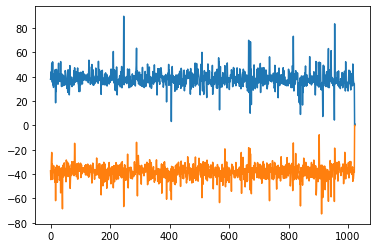

In [9]:
x_mx = np.max(np.array(train_data).reshape(-1, 1024),axis=0)
x_mn = np.min(np.array(train_data).reshape(-1, 1024),axis=0)
plt.plot(x_mx)
plt.plot(x_mn)

In [10]:
def preprocess(x):
    return 2*((x-x_mn)/(x_mx-x_mn) - .5)

def invPreprocess(xnew):
    return ((xnew/2)+.5)*(x_mx-x_mn) + x_mn
    
preprocess(test_data[0]).max()

1.0991392

In [11]:
a = torch.load(latent_path) 

In [12]:
a.keys(), a['y_hats'].shape

(dict_keys(['ys', 'y_hats']), torch.Size([10, 500, 1024]))

In [13]:
np.allclose(a['y_hats'][:,0,:], a['ys'][:,0,:])

True

In [14]:
np.allclose(a['ys'][0],preprocess(test_data[0]))

True

In [15]:
print('this diff should be zero or small\n')
for i in range(10):
    print((invPreprocess(a['ys'][i])-test_data[i]).abs().max())

this diff should be zero or small

tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)
tensor(1.1444e-05)


In [16]:
preds = a['y_hats']
preds[:,:,-2:] = a['ys'][:,:,-2:]

In [17]:
preds.min(), preds.max(), preds.shape

(tensor(-1.1473), tensor(1.), torch.Size([10, 500, 1024]))

In [18]:
actual_loader = DataLoader(dataset=torch.stack([*torch.tensor(test_data)]), batch_size=1)
predicted_loader = DataLoader(dataset=torch.stack([*torch.tensor(invPreprocess(preds))]), batch_size=1)
len(actual_loader), len(predicted_loader)

<ipython-input-18-6d490126e32b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_loader = DataLoader(dataset=torch.stack([*torch.tensor(invPreprocess(preds))]), batch_size=1)


(10, 10)

# Load model that created the latent vectors

In [19]:
use_sigmoid_output_layer = True
latentDim = 1024
filters = 128
num_conv = 4 # breaks when less than 2
stack = True
createStreamFcn = False
repeat = 3
skip_connection = False
act = nn.ELU()

AE = ConvDeconvFactor2(torch.ones([32, 1, 128, 128]).cuda(), filters, latentDim, num_conv, repeat,
                          skip_connection, stack, conv_k=3, last_k=3, 
                          act=act, return_z=True, stream=createStreamFcn, device=device, 
                          use_sigmoid_output_layer=use_sigmoid_output_layer)

if channel == 2:
    params = '/data/ccsi/pnnl_liquid_inlet/model_w_notebook/pnnl_ConvDeconvFactor2_GPUs0_channel2_gridsize128_latentDim1024_filters128_bz128_numConv4_jacobianFalse_sigmoid_outTrue_epochs1000_repeat3_lr0.0001'
elif channel == 1:
    params = '/data/ccsi/pnnl_liquid_inlet/model_w_notebook/pnnl_ConvDeconvFactor2_GPUs0_channel1_gridsize128_latentDim1024_filters128_bz32_numConv4_jacobianFalse_sigmoid_outFalse_epochs1000_repeat3_lr0.0001'
else:
    assert False, print('select right channel')

AE.load_state_dict(torch.load(params)) 
#AE = AE.to(device)

<All keys matched successfully>

In [20]:
recon = AE.generator.to(device)
recon

Sequential(
  (0): Linear(in_features=1024, out_features=65536, bias=True)
  (1): Reshape()
  (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (4): ELU(alpha=1.0)
  (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (7): ELU(alpha=1.0)
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (10): ELU(alpha=1.0)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): Sigmoid()
)

# Map latents to frames

In [21]:
recon.eval()
U_hats = []
Us = []
for act, pred in zip(actual_loader, predicted_loader):
    act = act[0].to(device)
    pred = pred[0].to(device)
    with torch.no_grad():
        Us.append(recon(act).detach().cpu())       
        U_hats.append(recon(pred).detach().cpu())        
        
Real_U = torch.stack(Us)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(U_hats)
#Surr_X_img = convertSimToImage(Surr_X)


In [22]:
Real_U = Real_U[:,1:]
Surr_U = Surr_U[:,1:]
Real_U.shape, Surr_U.shape

(torch.Size([10, 499, 1, 128, 128]), torch.Size([10, 499, 1, 128, 128]))

# Load raw frame data

In [23]:
class CCSI_2D_one_of_each_getitem(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = simLen
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)
            data.append((D,inletVelocity[idx]))
               
        self.data = data
    
    def __len__(self):
        return len(self.simLen*self.data)


    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        r_idx = r
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        y = np.expand_dims(y,1)
        p_x = np.hstack([p,self.t[r_idx]])
        p_y = np.vstack([p*np.ones((self.w,)),self.t[r_idx+1:r_idx+self.w+1]]).T
        X = x.astype('float32')
        Y = y.astype('float32')
        if self.AE:
            return X,X # this allows LR_finder to work
        else:
            return X, Y, p_x, p_y

sims = glob(os.path.join(dataDirec,'*.pkl'))
sims = sorted(sims)
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
testSimFiles = [sims[idx] for idx in testInds]
first_simulation = CCSI_2D_one_of_each_getitem(testSimFiles,doPreprocess=False,
                                           numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)

In [24]:
simulation = torch.stack([torch.tensor(frame[0]) for i, frame in enumerate(first_simulation) if i%500!=0]
                        ).unsqueeze(0)
simulation=simulation.reshape((10,499,*simulation.shape[2:]))
simulation.shape

torch.Size([10, 499, 1, 128, 128])

# Some error metrics:

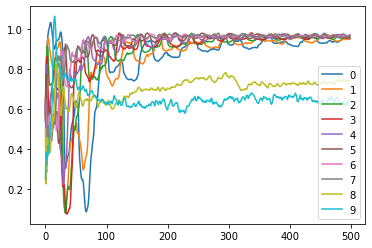

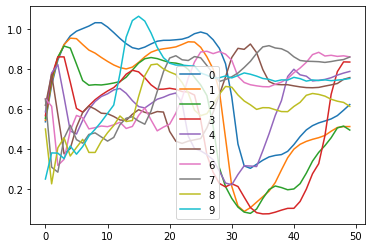

mean relative error was: 0.8524452447891235


In [25]:
sim_num=-1
rel_error_by_sim_and_frame = []
for sim in zip(simulation,Surr_U):
    for batch_real, batch_surr in [sim]:
        sim_num+=1
        rel_error_by_sim_and_frame.append([])
        for frame_real, frame_surr in zip(batch_real, batch_surr):
            assert frame_real.size()==torch.Size((1,128,128))
            rel_error_by_sim_and_frame[sim_num].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))

# note that this relative error uses the SVD reconstruction as the baseline
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
print('mean relative error was: {}'.format(torch.tensor(rel_error_by_sim_and_frame).mean()))

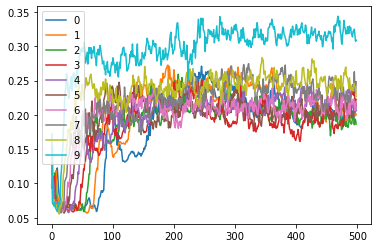

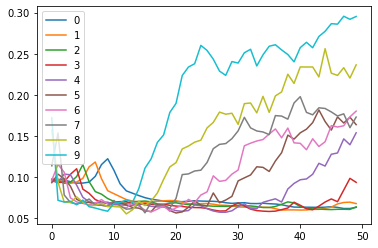

mean relative error was: 0.20945526659488678


In [26]:
sim_num=-1
rel_error_by_sim_and_frame = []
for sim in zip(simulation,Real_U):
    for batch_real, batch_surr in [sim]:
        sim_num+=1
        rel_error_by_sim_and_frame.append([])
        for frame_real, frame_surr in zip(batch_real, batch_surr):
            assert frame_real.size()==torch.Size((1,128,128))
            rel_error_by_sim_and_frame[sim_num].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))

# note that this relative error uses the SVD reconstruction as the baseline
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
print('mean relative error was: {}'.format(torch.tensor(rel_error_by_sim_and_frame).mean()))